In [1]:
options(warn=-1)

In [68]:
library(openxlsx)

In [70]:
sample_info <- read.xlsx("CAMDA_Challange_dataset_filenames.xlsx", startRow = 2)

In [71]:
sample_info <- sample_info[,c(1,2,3,4,6)]
colnames(sample_info)=c("ID","Category","Label","MCF7","PC3")

In [72]:
head(sample_info)

ID,Category,Label,MCF7,PC3
S No.,Data Type,Class Label,Compound .cel file name,Compound .cel file name
1,Training,1,5500024030403071907255.C05,5500024031723100807775.C05
2,Training,1,5500024030403071907253.A09,5500024031723100807771.A09
3,Training,0,5500024030402071707279.B01,5500024031723100807776.B01
4,Training,1,5500024030403071907257.G04,5500024030700072107992.G04
5,Training,0,'5500024037496121008324.E08,'5500024037498121108438.E02


## Cleaning columns.

In the colums, there are some extra characters, for example, '/' and extra spaces. 
In simple terms, we are remove extra characters.
gsub matches the pattern

In [73]:
sample_info$Category <- gsub("Training ", "Training", sample_info$Category)
sample_info$Category <- gsub("Validation ", "Validation", sample_info$Category)
sample_info$PC3 <- gsub("^\'","", sample_info$PC3)

## PC3 Data Setup

### Unzipping the files

In [74]:
# for unzipping the file
library(R.utils)

In [21]:
# unzip all files

count = 0

for (i in 1:nrow(sample_info)) {
    tmp_PC3_cel = sample_info$PC3[i]
    
    # Unzip bzfile if necessary
    file_handle = paste("PC3/", tmp_PC3_cel, ".CEL.bz2", sep = "")
    
    if (file.exists(file_handle)) {sample_info
        # remove temporary file if interrupted before.
        if (file.exists(paste("PC3/", tmp_PC3_cel, ".CEL.tmp", sep = ""))) {
            file.remove(paste("PC3/", tmp_PC3_cel, ".CEL.tmp", sep = ""))
        }
        # Unzip bz file
        bunzip2(file_handle)
        count = count + 1
    } else {
        cat(paste("There is no cel file named ", file_handle, "\n", sep = ""))
    }
}

print(count)

There is no cel file named PC3/Compound .cel file name .CEL.bz2
[1] 276


### RMA Normalizing

In [75]:
library(limma)
library(affy)

In [76]:
missing_drug <- NULL  # If there are mismatched cel file name.
Final_matrix_PC3 <- NULL
Final_matrix_PC3_type2 <- NULL

In [77]:
for (i in 2:nrow(sample_info)) {
    tmp_PC3_cel = sample_info$PC3[i]
    
    file_handle_2 = paste("PC3/", tmp_PC3_cel, ".CEL", sep = "")
    if (file.exists(file_handle_2)) {
        ## If using RMA
        data_rma <- just.rma(file_handle_2)  # rma normalization
        data_exp <- exprs(data_rma)

        if (is.null(nrow(Final_matrix_PC3)) || nrow(Final_matrix_PC3) == nrow(data_exp)) {
            Final_matrix_PC3 <- cbind(Final_matrix_PC3, data_exp)
        } else if (is.null(nrow(Final_matrix_PC3_type2)) || nrow(Final_matrix_PC3_type2) == nrow(data_exp)) {
            Final_matrix_PC3_type2 <- cbind(Final_matrix_PC3_type2, data_exp)
        } else {
            cat("Cannot match any existed ArrayType!\n")
        }
        # Unclassify_data[[n]] <- data_exp n=n+1
    } else {
        cat(paste("There is no cel file named ", file_handle_2, "\n", sep = ""))
        missing_drug <- cbind(missing_drug, sample_info$ID[i])
    }
}

In [79]:
common_probe <- intersect(rownames(Final_matrix_PC3),rownames(Final_matrix_PC3_type2))
Final_matrix_PC3_2 <- Final_matrix_PC3_type2[common_probe,]
data_PC3 <- cbind(Final_matrix_PC3, Final_matrix_PC3_2)

In [83]:
# writing a csv file
write.csv(data_PC3, file = "PC3_RMA.csv")
write.table(data_PC3, "./PC3_RMA.txt", sep="\t")

In [84]:
dim(data_PC3)
head(data_PC3)

[1] 22277   276

,5500024031723100807775.C05.CEL,5500024031723100807771.A09.CEL,5500024031723100807776.B01.CEL,5500024030700072107992.G04.CEL,5500024037498121108438.E02.CEL,5500024035736031208613.F03.CEL,5500024031723100807771.F10.CEL,5500024024213121906564.B01.CEL,5500024035736031208613.H04.CEL,5500024035736031208613.D01.CEL,...,EC2004070116AA.CEL,610611110806.B08.CEL,EC2004060209AA.CEL,610611110806.C02.CEL,610611110806.C08.CEL,610611110806.G07.CEL,EC2004070117AA.CEL,EC2005030717AA.CEL,610611110806.F06.CEL,610611110806.H12.CEL
1007_s_at,9.714717,10.007076,9.787519,9.741467,7.086778,8.743882,9.222144,9.877804,9.029211,8.992003,...,9.268386,9.120865,8.522663,8.677258,8.102172,9.262965,9.316974,8.558927,9.398136,9.606840
1053_at,8.885926,9.581804,8.980832,9.246175,6.117286,7.893153,8.889500,7.867493,7.965054,7.978511,...,8.164277,7.153838,7.060515,5.809041,5.449600,6.314850,8.259587,7.082478,6.501114,6.956225
117_at,5.523915,6.103792,6.041133,5.269015,3.514054,4.332979,5.577933,4.331766,4.795756,4.962872,...,7.334316,4.832424,6.460355,4.049920,3.253301,4.804609,6.698009,6.243701,4.808187,5.687255
121_at,7.035597,6.790657,6.940681,6.830067,4.248243,6.201345,5.908835,6.744030,6.075953,6.520990,...,9.464658,6.907116,8.506009,6.701780,5.720865,7.178489,9.399568,8.232961,7.238113,7.594323
1255_g_at,4.502539,4.963646,5.158741,4.592952,3.014705,4.034152,4.604870,3.857908,4.094590,4.374287,...,5.122540,3.163814,3.918600,2.904824,2.361652,3.759726,4.996464,3.714551,3.265466,3.490424
1294_at,5.212404,5.762783,6.072555,4.987831,3.359254,4.695990,5.350683,4.323544,4.474941,4.876034,...,7.328417,4.652221,6.664024,4.565203,3.444351,4.820261,7.234724,6.572356,5.117041,5.914645


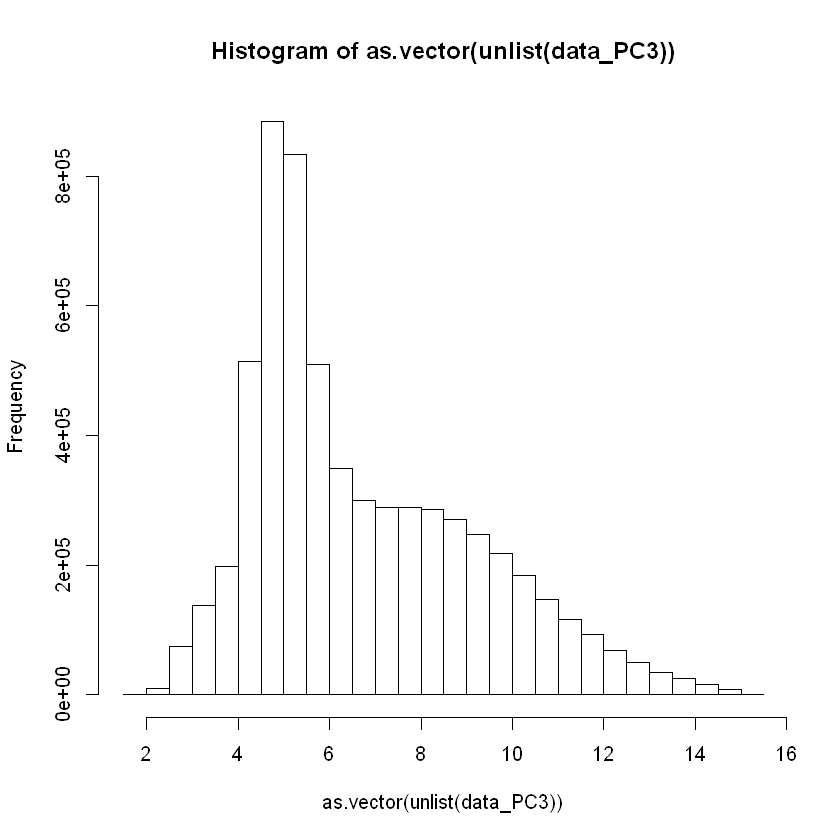

In [82]:
hist(as.vector(unlist(data_PC3)))

In [85]:
Label <- factor(sample_info$Label[2:277], levels = c(1,0))
Label

[1] 1    1    0    1    0    0    1    1    1    1    0    0    1    1    1   
 [16] 1    0    0    1    0    1    1    0    1    1    1    1    1    0    1   
 [31] 1    1    1    1    1    1    1    1    1    1    1    0    0    0    1   
 [46] 1    1    0    0    1    0    0    1    0    1    1    1    0    0    0   
 [61] 1    1    1    0    1    1    1    1    0    1    0    1    1    0    1   
 [76] 1    1    1    1    1    1    1    0    1    1    1    1    1    1    1   
 [91] 0    0    1    1    1    1    0    1    0    1    0    1    1    1    1   
[106] 1    1    1    1    1    1    0    1    0    1    0    1    0    0    1   
[121] 0    1    1    1    1    0    0    1    0    1    1    0    1    1    1   
[136] 0    0    0    0    0    1    1    1    1    0    1    1    1    1    1   
[151] 1    0    0    1    1    1    0    1    1    0    1    0    0    1    1   
[166] 0    1    1    1    0    1    1    1    1    0    1    1    1    1    1   
[181] 0    1    1    0    0    1    1    1    0    1    <NA> <NA> <NA> <NA> <NA>
[196] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[211] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[226] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[241] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[256] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[271] <NA> <NA> <NA> <NA> <NA> <NA>
Levels: 1 0

In [86]:
#Binding labels with the data
library(dplyr)
data_PC3_Labels <- mutate(as.data.frame(t(data_PC3)), Label=Label)
dim(data_PC3_Labels)

[1]   276 22278

In [88]:
# generating a csv file
write.table(data_PC3_Labels, "./PC3_RMA_labels.txt", sep="\t")

In [89]:
data_PC3_Labels[1:10, c(1:5,22275:22278)]

1007_s_at,1053_at,117_at,121_at,1255_g_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,Label
9.714717,8.885926,5.523915,7.035597,4.502539,4.614942,4.537976,4.664314,1
10.007076,9.581804,6.103792,6.790657,4.963646,5.422156,4.883759,5.329954,1
9.787519,8.980832,6.041133,6.940681,5.158741,5.523111,5.046227,5.481926,0
9.741467,9.246175,5.269015,6.830067,4.592952,4.583175,4.377955,4.941050,1
7.086778,6.117286,3.514054,4.248243,3.014705,2.878322,2.825760,3.208905,0
8.743882,7.893153,4.332979,6.201345,4.034152,4.219357,3.946508,3.944669,0
9.222144,8.889500,5.577933,5.908835,4.604870,5.047445,4.733086,5.282131,1
9.877804,7.867493,4.331766,6.744030,3.857908,3.861522,3.770792,3.891710,1
9.029211,7.965054,4.795756,6.075953,4.094590,4.410633,4.260362,4.460469,1
8.992003,7.978511,4.962872,6.520990,4.374287,4.571669,4.429130,4.696386,1
